In [341]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 120
rcParams["savefig.dpi"] = 120

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import units as u

import h5py
import glob

In [211]:
### Read in MASCARA data.

mascara_data_LSS = glob.glob('*LSS*')#'red0_vmag_2018Q1LSS.hdf5'
mascara_data_LSC = glob.glob('*LSC*')#sys.argv[2]
mascara_data_LSE = glob.glob('*LSE*')
mascara_data_LSW = glob.glob('*LSW*')

In [212]:
def get_lightcurves(mascara_data, ascc):
    
    camera = []
    for i in range(len(mascara_data)):
        camera.append(h5py.File(mascara_data[i], 'r'))
        
    lc = []
    for i in range(len(camera)):
        lc.append(camera[i]['lightcurves'][ascc][()])
        
    # Remove points binned from <=45 points.
    mask = []
    for i in range(len(lc)):
        mask.append(lc[i]['nobs'] > 45)
        lc[i] = lc[i][mask[i]]

    # Convert lst sequence to lst index.
    lstidx = []
    for i in range(len(lc)):
        lstidx.append(lc[i]['lstseq'] % 270)
        
    return lc, lstidx

lss_lc, lss_lstidx_season = get_lightcurves(mascara_data_LSS, '2017081')
lsc_lc, lsc_lstidx_season = get_lightcurves(mascara_data_LSC, '2017081')
#lse_lc, lse_lstidx_season = get_lightcurves(mascara_data_LSE, '2017081')
#lsw_lc, lsw_lstidx_season = get_lightcurves(mascara_data_LSW, '2017081')

In [213]:
def collect_data(lc, idx):
    jd = []
    for i in range(len(lc)):
        jd.append(lc[i]['jd'])
    
    index = []
    for i in range(len(idx)):
        index.append(idx[i])
    
    return np.concatenate(jd) , np.concatenate(index)

lss_jd, lss_lstidx = collect_data(lss_lc, lss_lstidx_season)
lsc_jd, lsc_lstidx = collect_data(lsc_lc, lsc_lstidx_season)
#lse_jd, lse_lstidx = collect_data(lse_lc, lse_lstidx_season)

In [214]:
### Secondary data calibriation on MASCARA by Local linear method.

# Compute a moving mean along the x-axis.
def moving_mean(x, y, yerr=None, window=3.):
    
    # Set the weights.
    if yerr is None:
        weights = np.ones_like(y)
    else:
        weights = 1/yerr**2

    # Sums for computing the mean.
    sum1 = np.append(0, np.cumsum(weights*y))
    sum2 = np.append(0, np.cumsum(weights))
    
    # Indices at the start and end of the window.
    i = np.searchsorted(x, x - window/2.)
    j = np.searchsorted(x, x + window/2.)
    
    # Compute the mean.
    mean = (sum1[j] - sum1[i])/(sum2[j] - sum2[i])
    
    return mean

# Fit a curve for local linear
def linfit(lstidx, x, y, sky, mag, emag):
    
    sort = np.argsort(lstidx)
    invsort = np.argsort(sort)
    
    lstidx = lstidx[sort]
    x = x[sort]
    y = y[sort]
    sky = sky[sort]
    mag = mag[sort]
    emag = emag[sort]

    _, idx = np.unique(lstidx, return_inverse=True)

    nobs = np.bincount(idx)
    strides = np.append(0, np.cumsum(nobs))

    xbar = np.bincount(idx, x)/np.bincount(idx)
    ybar = np.bincount(idx, y)/np.bincount(idx)

    mat = np.column_stack([np.ones(len(lstidx)), x-xbar[idx], y-ybar[idx], sky])

    pars = np.zeros((len(nobs), 4))
    pars[:,0] = np.bincount(idx, mag/emag**2)/np.bincount(idx, 1/emag**2)

    for i in range(len(nobs)):

        if nobs[i] < 5:
             continue

        i1 = strides[i]
        i2 = strides[i+1]

        pars[i] = np.linalg.lstsq(mat[i1:i2]/emag[i1:i2,None], mag[i1:i2]/emag[i1:i2], rcond=None)[0]

    fit = np.sum(pars[idx]*mat, axis=1)

    fit1 = pars[idx,0]
    fit2 = fit - pars[idx,0]

    return fit1[invsort], fit2[invsort], (nobs > 4)[idx][invsort]

def local_lin(jd, lstseq, x, y, sky, mag, emag, window=5., maxiter=50, dtol=1e-3):
     
    lstidx = (lstseq % 270)
    fit0 = np.zeros(len(jd))
    fit1 = np.zeros(len(jd))

    fit = np.zeros_like(mag)
    for niter in range(maxiter):
        fit1, fit2, mask = linfit(lstidx, x, y, sky, mag - fit0, emag)
        fit0 = moving_mean(jd, mag - fit1 - fit2, emag, window)

        if niter > 0:

            if np.all(np.abs(fit - fit0 - fit1 - fit2) < dtol):
                break

        fit = fit0 + fit1 + fit2

    return fit#, fit0, fit1, fit2, mask

In [215]:
def sec_cali(lc):
    
    vmag = []
    for i in range(len(lc)):
        vmag.append(lc[i]['mag0'] - local_lin(lc[i]['jd'],
                                              lc[i]['lstseq'],
                                              lc[i]['x'],
                                              lc[i]['y'],
                                              lc[i]['sky'],
                                              lc[i]['mag0'],
                                              lc[i]['emag0']))
    
    return np.concatenate([vmag[0], vmag[1], vmag[2], vmag[3]])*(-1)

lss_mag = sec_cali(lss_lc)
lsc_mag = sec_cali(lsc_lc)

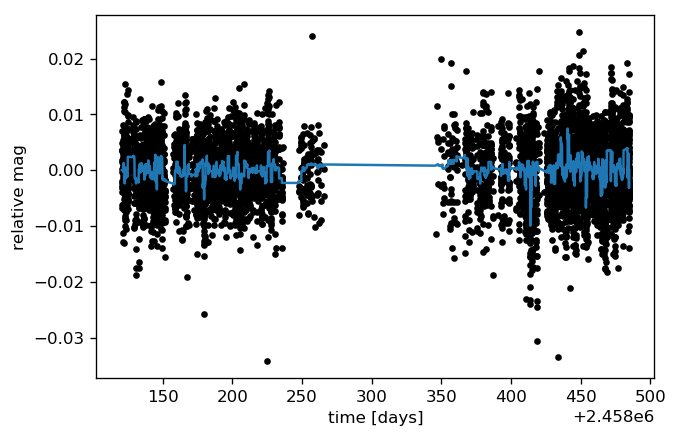

In [216]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 4))
ax.plot(lss_jd*u.d, lss_mag, ".k")
#ax.set_xlim(lss_jd.min().value, lss_jd.max().value)
ax.set_xlabel("time [days]")
ax.set_ylabel("relative mag");

from scipy.signal import medfilt

trend = medfilt(lss_mag, 45)
mu = np.median(lss_mag)

plt.plot(lss_jd, trend)
#plt.gca().invert_yaxis()

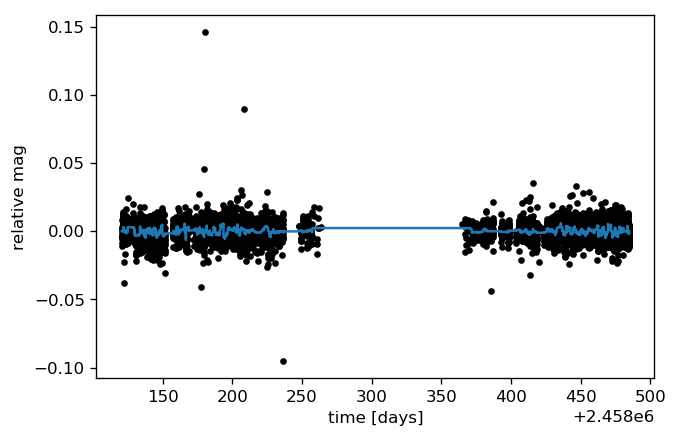

In [217]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 4))
ax.plot(lsc_jd*u.d, lsc_mag, ".k")
#ax.set_xlim(lsc_jd.min().value, lsc_jd.max().value)
ax.set_xlabel("time [days]")
ax.set_ylabel("relative mag");

from scipy.signal import medfilt

trend = medfilt(lsc_mag, 45)
mu = np.median(lsc_mag)

plt.plot(lsc_jd, trend)
#plt.gca().invert_yaxis()

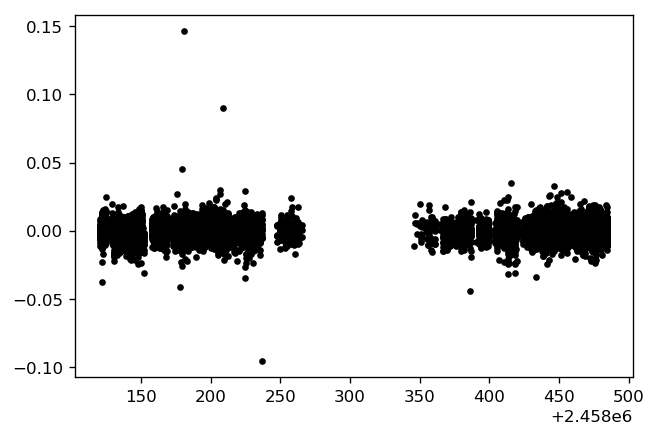

In [218]:
ls_jd = np.concatenate([lss_jd, lsc_jd])
ls_mag = np.concatenate([lss_mag, lsc_mag])

plt.plot(ls_jd, ls_mag, '.k')
#plt.gca().invert_yaxis()

In [219]:
from astropy.stats import BoxLeastSquares as BLS

durations = 6.595 * u.h
model = BLS(lss_jd*u.d, lss_mag)
results = model.autopower(durations, frequency_factor=5.0)
print(results)

          depth: array([0.00050072, 0.00050169, 0.00049825, ..., 0.01266048, 0.01297657,
       0.01155837])
      depth_err: array([0.02447968, 0.02447964, 0.02447964, ..., 0.26754196, 0.24284506,
       0.25848949])
      depth_snr: array([0.02045467, 0.0204943 , 0.02035365, ..., 0.04732148, 0.05343558,
       0.04471504])
       duration: <Quantity [0.27479167, 0.27479167, 0.27479167, ..., 0.27479167, 0.27479167,
           0.27479167] d>
 log_likelihood: array([0.00041733, 0.00041933, 0.00041359, ..., 0.00112201, 0.00143133,
       0.00100197])
      objective: 'likelihood'
         period: <Quantity [  0.54958333,   0.54958646,   0.54958959, ..., 181.59656717,
           181.93861086, 182.28194549] d>
          power: array([0.00041733, 0.00041933, 0.00041359, ..., 0.00112201, 0.00143133,
       0.00100197])
   transit_time: <Quantity [2.30114654e-05, 3.03438207e-01, 5.72672673e-02, ...,
           1.40955374e+02, 5.91874427e+01, 3.09163577e+01] d>


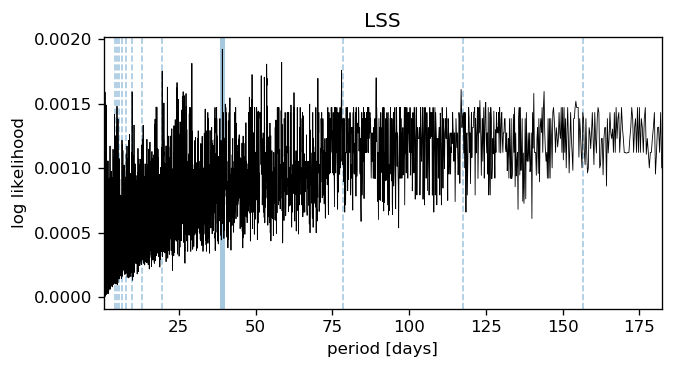

In [232]:
# Find the period of the peak
period = results.period[np.argmax(results.power)]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# Highlight the harmonics of the peak period
ax.axvline(period.value, alpha=0.4, lw=3)
for n in range(2, 10):
    ax.axvline(n*period.value, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period.value / n, alpha=0.4, lw=1, linestyle="dashed")

# Plot the periodogram
ax.plot(results.period, results.power, "k", lw=0.5)

ax.set_xlim(results.period.min().value, results.period.max().value)
ax.set_title('LSS')
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood");

In [233]:
abs(period.value-39.500272)/39.500272 *24*u.h

<Quantity 0.18997225 h>

In [234]:
index = np.argmax(results.power)
period = results.period[index]
t0 = results.transit_time[index]
duration = results.duration[index]

model.compute_stats(period, duration, t0)

{'transit_times': <Quantity [2458179.55073437, 2458218.73834156, 2458257.92594876,
            2458297.11355595, 2458336.30116314, 2458375.48877033,
            2458414.67637753, 2458453.86398472] d>,
 'per_transit_count': array([32,  0,  0,  0,  0,  0, 19, 27]),
 'per_transit_log_likelihood': array([0.0006631 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.0007561 , 0.00050255]),
 'depth': (0.00701965031316366, 0.11389511347670016),
 'depth_phased': (0.0006214157025648304, 0.24284872883269387),
 'depth_half': (0.005876017854833403, 0.1033358189272445),
 'depth_odd': (0.006161358781451215, 0.1928435145147345),
 'depth_even': (0.00747403994759966, 0.1405682296630803),
 'harmonic_amplitude': 0.0003557481519938911,
 'harmonic_delta_log_likelihood': -0.0016972448267195545}

In [235]:
period

<Quantity 39.18760719 d>

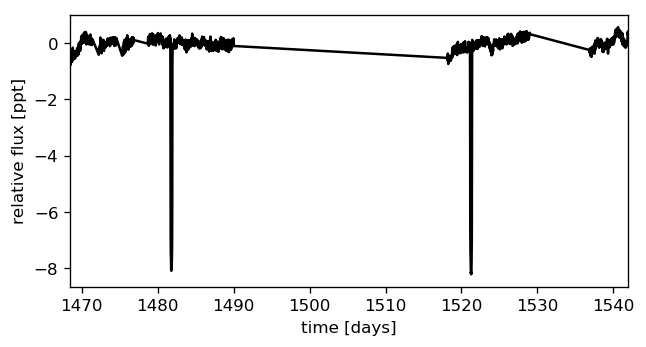

In [236]:
tess_file = 'tess_2017081.fits'#sys.argv[1]

with fits.open(tess_file) as tess_data:
    data = tess_data[1].data
    t = data["TIME"]
    y = data["SAP_FLUX"]
    q = data["QUALITY"]

# This is from the EVEREST source. These are the flagged data points
# that should be removed. Ref: https://github.com/rodluger/everest
m = np.isfinite(t) & np.isfinite(y)
for b in [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12]:
    m &= (q & (2 ** (b - 1))) == 0

t = np.ascontiguousarray(t[m], dtype=np.float64) * u.day
y = np.ascontiguousarray(y[m], dtype=np.float64)
y = (y / np.median(y) - 1)*1e3

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3))
ax.plot(t, y, "k")
ax.set_xlim(t.min().value, t.max().value)
ax.set_xlabel("time [days]")
ax.set_ylabel("relative flux [ppt]");

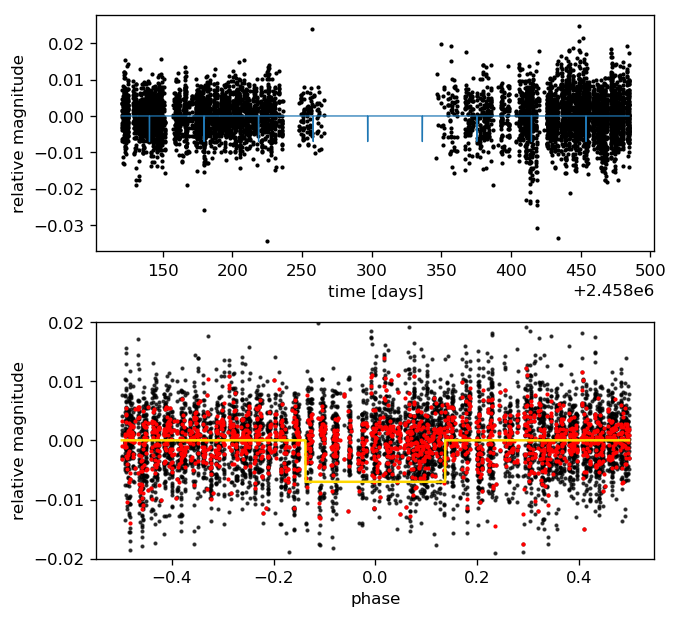

In [239]:
# Extract the parameters of the best-fit model

fig, axes = plt.subplots(2, 1, figsize=(6, 6))
fig.subplots_adjust(hspace=0.3)

# Plot the light curve and best-fit model
ax = axes[0]
ax.plot(lss_jd, lss_mag, ".k", ms=3)
bls_x = np.linspace((lss_jd*u.d).min(), (lss_jd*u.d).max(), 3*len(lss_jd))
bls_box = model.model(bls_x, period, duration, t0)
ax.plot(bls_x, bls_box, lw=0.75)
#ax.set_xlim(190+2458000, 200+2458000)
#ax.set_ylim(-0.05,0.05)
ax.set_xlabel("time [days]")
ax.set_ylabel("relative magnitude");


# Plot the folded data points within 0.5 days of the transit time

ax = axes[1]
T0 = 2457000
epoch = 1471.925+T0
P = 39.500272

lss_phase = (lss_jd - epoch)/period.value
lss_phase = np.mod(lss_phase+.5, 1)-.5
#x = ((mascara_jd - t0 + 0.5*period) % period)/period - 0.5
#m = np.abs(x) < 0.5 * u.day
#ax.plot(x[m], y_filt[m], ".k", ms=3)
ax.plot(lss_phase, lss_mag, '.k', ms=3, alpha=0.7)


### Bin MASCARA data points.

#period = 39.500272* u.d

def spec_digitize_median(x,y,numbins):
    mybins = np.linspace(min(x),max(x),numbins)
    digitized = np.digitize(x,mybins)
    xmedians = [np.median(x[digitized==i]) for i in range(1,len(mybins))]
    ymedians = [np.median(y[digitized==i]) for i in range(1,len(mybins))]
    return xmedians,ymedians

bins = spec_digitize_median(lss_phase, lss_mag, 3000)

binned_lss_phase,binned_lss_mag = np.asarray(bins)[0],np.asarray(bins)[1]

# Over-plot the best fit model
x = np.linspace((lss_phase*u.d).min(), (lss_phase*u.d).max(), 3*len(lss_jd))
f = model.model(x+t0, period, duration, t0)
ax.plot(binned_lss_phase, binned_lss_mag, '.r', ms=3)
ax.plot(x, f, c='gold', lw=1.5)
#ax.set_xlim(-0.2,0.2)
ax.set_ylim(-0.02, 0.02)
ax.set_xlabel("phase")
#ax.hlines(-0.006,-0.5,0.5, color='red')
ax.set_ylabel("relative magnitude");

In [138]:
P = 39.500272
durations = 6.595 * u.h
model = BLS(lss_jd*u.d, lss_mag)
results = model.power(P, durations)
print(results)

          depth: array([0.00632097])
      depth_err: array([0.17450956])
      depth_snr: array([0.03622131])
       duration: <Quantity [0.27479167] d>
 log_likelihood: array([0.00065925])
      objective: 'likelihood'
         period: <Quantity [39.500272] d>
          power: array([0.00065925])
   transit_time: <Quantity [38.18925468] d>


In [143]:
period = results.period
t0 = results.transit_time
duration = results.duration

model.compute_stats(period, duration, t0)

{'transit_times': <Quantity [2458179.61608668] d>,
 'per_transit_count': array([33]),
 'per_transit_log_likelihood': array([0.00065925]),
 'depth': (0.006320965115537842, 0.1745095623860093),
 'depth_phased': (0.0014715686362743393, 0.15665802277761207),
 'depth_half': (0.0036381882011008106, 0.1168974153335535),
 'depth_odd': (0.006320965115537842, 0.1745095623860093),
 'depth_even': (0.0, inf),
 'harmonic_amplitude': 0.000376369937516074,
 'harmonic_delta_log_likelihood': -0.00042035811246549093}

In [144]:
t0

<Quantity [38.18925468] d>

In [145]:
epoch

2458471.925

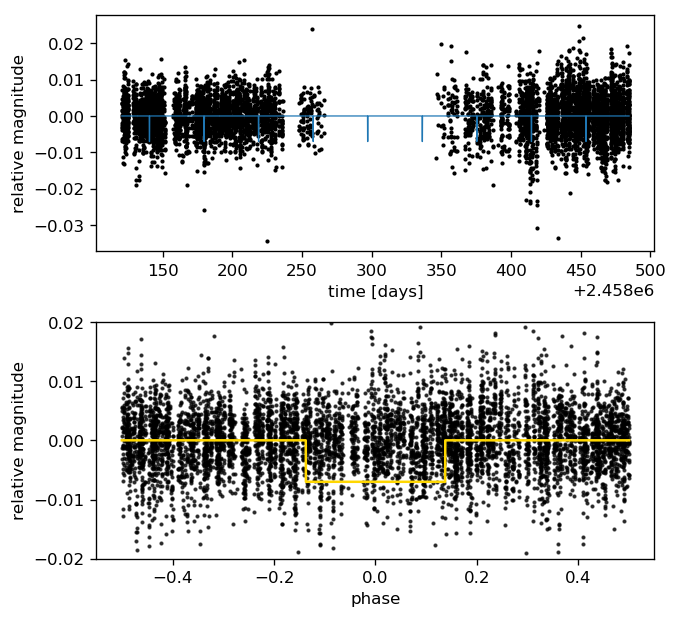

In [249]:
# Extract the parameters of the best-fit model

fig, axes = plt.subplots(2, 1, figsize=(6, 6))
fig.subplots_adjust(hspace=0.3)

# Plot the light curve and best-fit model
ax = axes[0]
ax.plot(lss_jd, lss_mag, ".k", ms=3)
bls_x = np.linspace((lss_jd*u.d).min(), (lss_jd*u.d).max(), 3*len(lss_jd))
bls_box = model.model(bls_x, period, duration, t0)
ax.plot(bls_x, bls_box, lw=0.75)
#ax.set_xlim(190+2458000, 200+2458000)
#ax.set_ylim(-0.05,0.05)
ax.set_xlabel("time [days]")
ax.set_ylabel("relative magnitude");


# Plot the folded data points within 0.5 days of the transit time

ax = axes[1]
T0 = 2457000
epoch = 1471.925+T0
P = 39.500272

lss_phase = (lss_jd - epoch)/P#period.value
lss_phase = np.mod(lss_phase+.5, 1)-.5
#x = ((mascara_jd - t0 + 0.5*period) % period)/period - 0.5
#m = np.abs(x) < 0.5 * u.day
#ax.plot(x[m], y_filt[m], ".k", ms=3)
ax.plot(lss_phase, lss_mag, '.k', ms=3, alpha=0.7)


### Bin MASCARA data points.

#period = 39.500272* u.d

def spec_digitize_median(x,y,numbins):
    mybins = np.linspace(min(x),max(x),numbins)
    digitized = np.digitize(x,mybins)
    xmedians = [np.median(x[digitized==i]) for i in range(1,len(mybins))]
    ymedians = [np.median(y[digitized==i]) for i in range(1,len(mybins))]
    return xmedians,ymedians

bins = spec_digitize_median(lss_phase, lss_mag, 1000)

binned_lss_phase,binned_lss_mag = np.asarray(bins)[0],np.asarray(bins)[1]

# Over-plot the best fit model
x = np.linspace((lss_phase*u.d).min(), (lss_phase*u.d).max(), 3*len(lss_jd))
f = model.model(x+t0, period, duration, t0)
#ax.plot(binned_lss_phase, binned_lss_mag, '.r', ms=3)
ax.plot(x, f, c='gold', lw=1.5)
#ax.set_xlim(-0.2,0.2)
ax.set_ylim(-0.02, 0.02)
ax.set_xlabel("phase")
#ax.hlines(-0.006,-0.5,0.5, color='red')
ax.set_ylabel("relative magnitude");

In [250]:
lss_mag

array([ 0.00023924,  0.00339187,  0.00705954, ..., -0.00446139,
       -0.00360932,  0.0029801 ])

(2458179, 2458180)

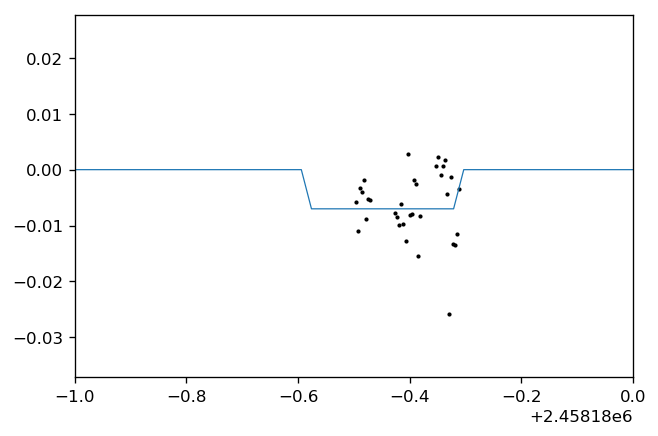

In [242]:
bls_x = np.linspace((lss_jd*u.d).min(), (lss_jd*u.d).max(), 3*len(lss_jd))
bls_box = model.model(bls_x, period, duration, t0)
plt.plot(lss_jd, lss_mag, ".k", ms=3)
plt.plot(bls_x, bls_box, lw=0.75)
tempa = 2458000
plt.xlim(179+tempa,180+tempa)
#plt.xlim(450+tempa, 460+tempa)

In [342]:
import math

def bls(t, x, qmi, qma, fmin, df, nf, nb):
    """Frist trial, BLS algorithm, only minor modification from author's code"""
    
    n = len(t); rn = len(x)
    #! use try
    if n != rn:
        print ("Different size of array, t and x")
        return 0

    rn = float(rn) # float of n

    minbin = 5
    nbmax = 2000
    if nb > nbmax:
        print ("Error: NB > NBMAX!")
        return 0

    tot = t[-1] - t[0] # total time span

    if fmin < 1.0/tot:
        print ("Error: fmin < 1/T")
        return 0

    # parameters in binning (after folding)
    kmi = int(qmi*nb) # nb is number of bin -> a single period
    if kmi < 1: 
        kmi = 1
    kma = int(qma*nb) + 1
    kkmi = rn*qmi # to check the bin size
    if kkmi < minbin: 
        kkmi = minbin

    # For the extension of arrays (edge effect: transit happen at the edge of data set)
    nb1 = nb + 1
    nbkma = nb + kma
        
    # Data centering
    t1 = t[0]
    u = t - t1
    s = np.mean(x) # ! Modified
    v = x - s

    bpow = 0.0
    p = np.zeros(nf)
    # Start period search
    for jf in range(nf):
        f0 = fmin + df*jf # iteration in frequency not period
        p0 = 1.0/f0

        # Compute folded time series with p0 period
        ibi = np.zeros(nbkma)
        y = np.zeros(nbkma)
        for i in range(n):
            ph = u[i]*f0 # instead of t mod P, he use t*f then calculate the phase (less computation)
            ph = ph - int(ph)
            j = int(nb*ph) # data to a bin 
            ibi[j] = ibi[j] + 1 # number of data in a bin
            y[j] = y[j] + v[i] # sum of light in a bin
        
        # Extend the arrays  ibi()  and  y() beyond nb by wrapping
        for j in range(nb1, nbkma):
            jnb = j - nb
            ibi[j] = ibi[jnb]
            y[j] = y[jnb]

        # Compute BLS statictics for this trial period
        power = 0.0

        for i in range(nb): # shift the test period
            s = 0.0
            k = 0
            kk = 0
            nb2 = i + kma
            # change the size of test period (from kmi to kma)
            for j in range(i, nb2): 
                k = k + 1
                kk = kk + ibi[j]
                s = s + y[j]
                if k < kmi: continue # only calculate SR for test period > kmi
                if kk < kkmi: continue # 
                rn1 = float(kk)
                powo = s*s/(rn1*(rn - rn1))
                if powo > power: # save maximum SR in a test period
                    power = powo # SR value
                    jn1 = i # 
                    jn2 = j
                    rn3 = rn1
                    s3 = s

        power = math.sqrt(power)
        p[jf] = power

        if power > bpow:
            bpow = power # Save the absolute maximum of SR
            in1 = jn1
            in2 = jn2
            qtran = rn3/rn
            # depth = -s3*rn/(rn3*(rn - rn3))
            # ! Modified
            high = -s3/(rn - rn3)
            low = s3/rn3
            depth = high - low
            bper = p0
    
    # ! add
    sde = (bpow - np.mean(p))/np.std(p) # signal detection efficiency

    return bpow, in1, in2, qtran, depth, bper, sde, p, high, low


[0. 0. 0. ... 0. 0. 0.]
[-0.00498673  0.00527636 -0.00031152 ...  0.00531798  0.00208385
 -0.00809706]


Text(0, 0.5, 'Relative Intensity')

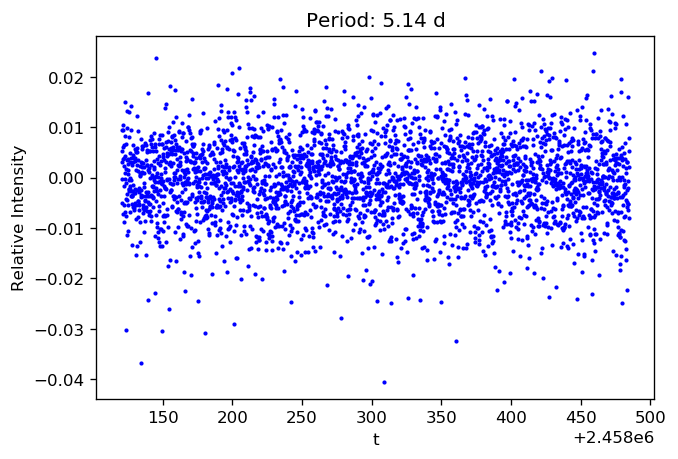

In [388]:
import batman #Bad-Ass Transit Model cAlculatioN
import astropy.units as u
from astropy.constants import G, R_sun, M_sun, R_jup, M_jup, R_earth, M_earth

params = batman.TransitParams() # object to store the transit parameters
params.t0 = 1.0 # time of inferior conjunction 
params.per = 5.14 # orbital period (days)
params.rp = R_earth/R_sun*15 # planet radius (in units of stellar radii)

# calculate semi-major axis from orbital period value
a = (((params.per*u.day)**2 * G * (M_sun + M_earth) / (4*np.pi**2))**(1./3)).to(R_sun).value 

params.a = a # semi-major axis (in units of stellar radii)
params.inc = 90.0  # orbital inclination (in degrees)
params.ecc = 0. # eccentricity
params.w = 90. # longitude of periastron (in degrees), 90 for circular
params.u = [0.1, 0.3] # limb darkening coefficients
params.limb_dark = "quadratic" # limb darkening model

t = np.linspace(min(lss_jd), max(lss_jd), 3000) # times at which to calculate the light curve
m = batman.TransitModel(params, t) # initializes the model
f = m.light_curve(params)-1
print(f)

# add gaussian error 
rs = np.random.RandomState(seed=13)

errors = 0.007*np.ones_like(f) # if comparable to the depth of the transit
f += errors*rs.randn(len(t))
print (f)

#plt.plot(lss_jd, lss_mag, '.k', ms=3, alpha=0.7)
plt.plot(t, f, '.b', ms=3)
plt.title("Period: {0} d".format(params.per))
plt.xlabel("t")
plt.ylabel("Relative Intensity")

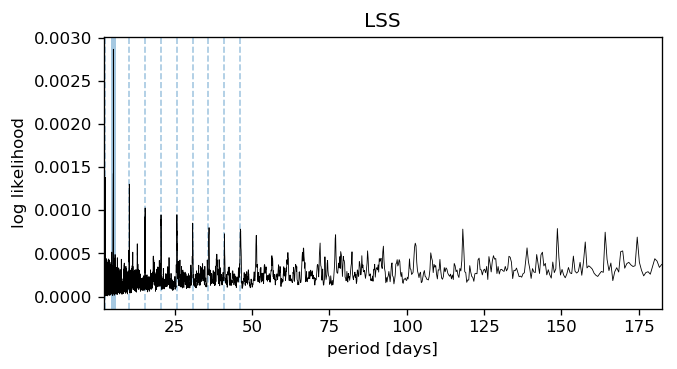

In [385]:
results = BLS(t,f).autopower(1, frequency_factor=3.0)

# Find the period of the peak
period = results.period[np.argmax(results.power)]
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# Highlight the harmonics of the peak period
ax.axvline(period, alpha=0.4, lw=3)
for n in range(2, 10):
    ax.axvline(n*period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period / n, alpha=0.4, lw=1, linestyle="dashed")

# Plot the periodogram
ax.plot(results.period, results.power, "k", lw=0.5)

ax.set_xlim(results.period.min(), results.period.max())
ax.set_title('LSS')
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood");

In [386]:
period

5.127711427317263

In [366]:
qmi = 0.01
qma = 0.1
fmin = 0.125 
df = 0.001 
nf = 1000
nb = 300
res = bls(t, f, qmi, qma, fmin, df, nf, nb)
print ("Best SR: ", res[0], "\nIngress: ", res[1], "\nEgress: ", res[2], "\nq: ", res[3], \
"\nDepth: ", res[4], "\nPeriod: ", res[5], "\nSDE: ", res[6])

Best SR:  0.0017521836765669234 
Ingress:  60 
Egress:  76 
q:  0.057 
Depth:  0.007557642696914314 
Period:  2.570694087403599 
SDE:  14.530460888310635


Text(0, 0.5, '$SR$')

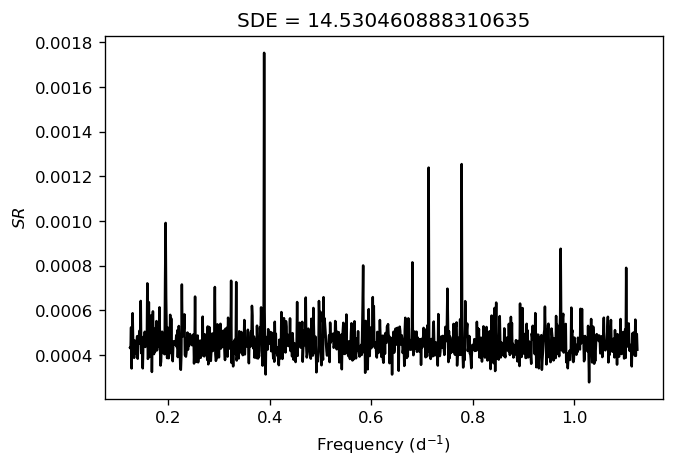

In [389]:
freq = np.arange(0.125, 1.125, 0.001)
plt.plot(freq, res[7], 'k')
plt.title("SDE = {0}".format(res[6]))
plt.xlabel(r"Frequency (d$^{-1}$)")
plt.ylabel(r"$SR$")

Text(0, 0.5, 'Mean value of $x(\\phi)$ in a bin')

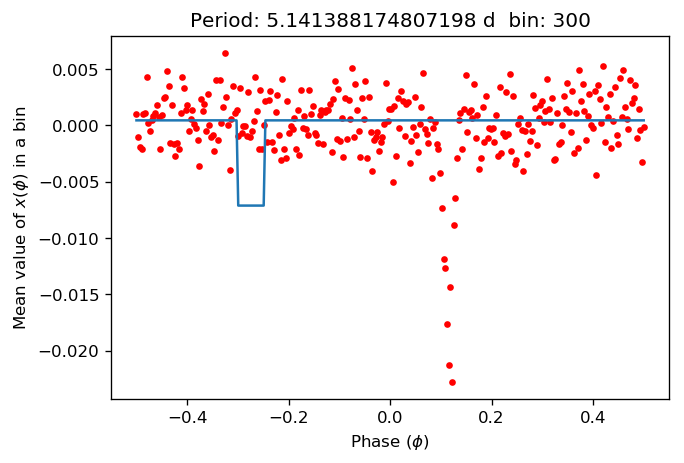

In [400]:
t1 = t[0]
u = t - t1
s = np.mean(f)
v = f - s

f0 = 1.0/res[5]/2 #  freq = 1/T
nbin = nb # number of bin
n = len(t)
ibi = np.zeros(nbin)
y = np.zeros(nbin)
phase = np.linspace(-0.5, 0.5, nbin)

for i in range(n):
    ph = u[i]*f0 
    ph = ph - int(ph)
    j = int(nbin*ph) # data to a bin 
    ibi[j] = ibi[j] + 1.0 # number of data in a bin
    y[j] = y[j] + v[i] # sum of light in a bin


plt.plot(phase, y/ibi, 'r.')
fite = np.zeros(nbin) + res[8] # H
fite[res[1]:res[2]] = res[9] # L    

plt.plot(phase, fite)
plt.title("Period: {0} d  bin: {1}".format(1/f0, nbin))
plt.xlabel(r"Phase ($\phi$)")
plt.ylabel(r"Mean value of $x(\phi)$ in a bin")

Text(0, 0.5, 'Mean value of $x(\\phi)$ in a bin')

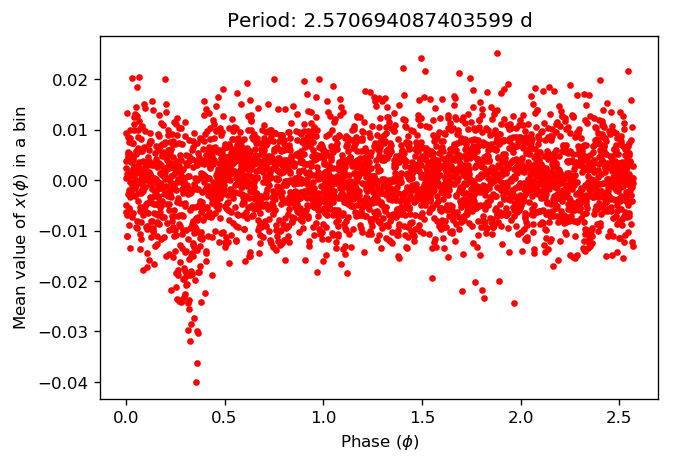

In [360]:
T0 = res[5]
n = len(t)
y = np.zeros(n)
y = t % T0

plt.plot(y, v, 'r.')
plt.title("Period: {0} d".format(1/f0))
plt.xlabel(r"Phase ($\phi$)")
plt.ylabel(r"Mean value of $x(\phi)$ in a bin")

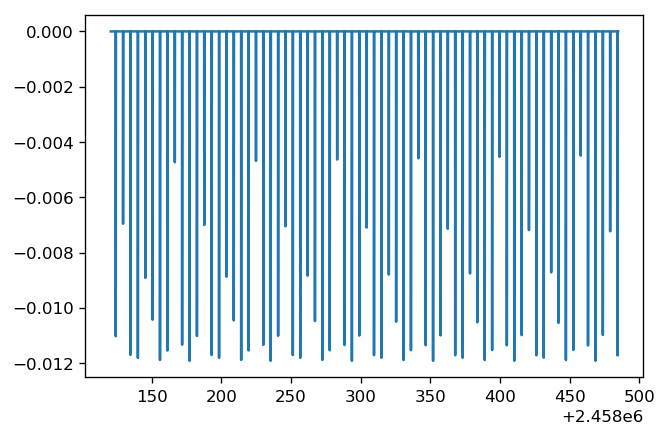

In [323]:
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 0.                        #time of inferior conjunction
params.per = 5.3                     #orbital period
params.rp = 0.1                       #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 87.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients

t = np.linspace(min(lss_jd), max(lss_jd), 5000)  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model

flux = m.light_curve(params)          #calculates light curve

radii = np.linspace(0.09, 0.11, 20)
for r in radii:
        params.rp = r                           #updates planet radius
        new_flux = m.light_curve(params)-1      #recalculates light curve

#plt.xlim(min(lss_jd)+30, min(lss_jd)+50)
plt.plot(t, new_flux)